# Project: Stock Price Prediction

In [378]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Overall Goal

Predict stock price (closing) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [365]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [366]:
def plot_chart(df, col, is_df=True): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        if is_df:
            ax.plot(df['Date'], df[col[ind]])
        else:
            ax.plot(df['Date'], col[ind])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

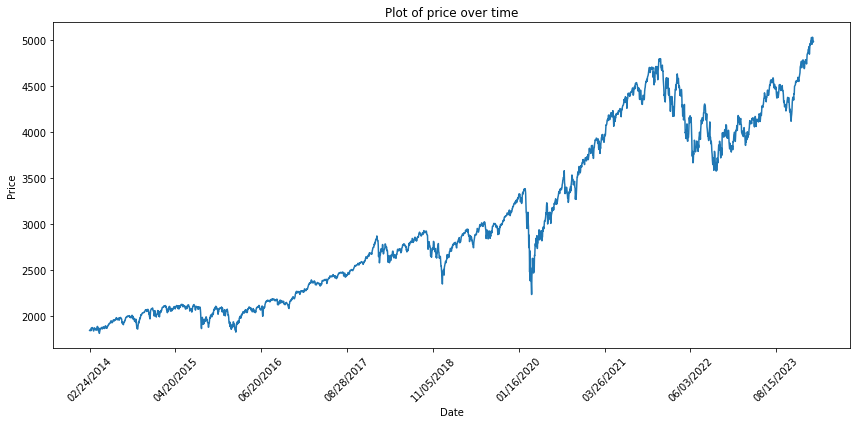

In [367]:
# plotting data

plot_chart(df, ["Close/Last"])

In [418]:
# normalizing

closing_prices = df["Close/Last"].values

minmax_scaler = MinMaxScaler(feature_range=(0,1))

closing_prices_norm = minmax_scaler.fit_transform(closing_prices.reshape(-1, 1))
closing_prices_norm = closing_prices_norm.flatten()

In [419]:
def prep_data(feature_vec_len, data):
    features = []
    labels = []
    data_len = len(data)

    for ind in range(data_len):
        feature_vec = []
        if ind < data_len - feature_vec_len:
            for ind2 in range(feature_vec_len):
                feature = data[ind + ind2]
                feature_vec.append(feature)

            label = data[ind + ind2 + 1]
            labels.append(label)
            features.append(feature_vec)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [426]:
# generating feature and label vectors

feature_vec_len = 1
features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)

In [421]:
# splitting into sets

X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

### 1. Linear Regression

In [339]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [422]:
def fit_lin_reg(feature_vec_len, features_norm):
    linear_regressor = LinearRegression()
    days = np.arange(feature_vec_len).reshape(-1, 1)
    lin_reg_predictions = []

    for feature in features_norm:
        linear_regressor.fit(days, feature)
        pred = linear_regressor.predict(np.array(feature_vec_len + 1).reshape(-1, 1))
        lin_reg_predictions.append(pred[0])

    return np.array(lin_reg_predictions)

In [427]:
# fit models to every feature vector (split is not needed here)
lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

In [428]:
# eval

lin_reg_predictions = minmax_scaler.inverse_transform(lin_reg_predictions_norm.reshape(-1, 1))
lin_reg_predictions = lin_reg_predictions.flatten()

labels = minmax_scaler.inverse_transform(labels_norm.reshape(-1, 1))
labels = labels.flatten()

mae = mean_absolute_error(labels, lin_reg_predictions) #add feature_vec_len: to remove leading zeros

mape = np.mean(np.abs((labels - lin_reg_predictions) / labels)) * 100

print(mae)
print(f"{round(mape, 3)}%")

22.46177470355732
0.722%


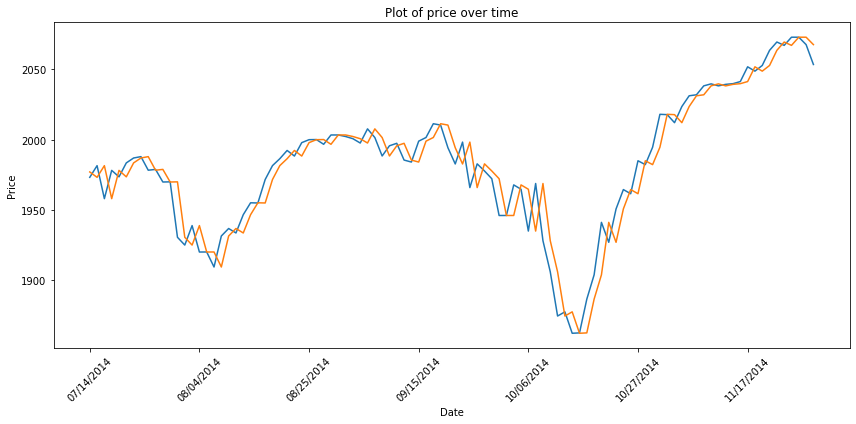

In [429]:
# plotting

plot_chart(df[100:200], [labels[100:200], lin_reg_predictions[100:200]], is_df=False)

In [434]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    lin_reg_predictions = minmax_scaler.inverse_transform(lin_reg_predictions_norm.reshape(-1, 1))
    lin_reg_predictions = lin_reg_predictions.flatten()

    labels = minmax_scaler.inverse_transform(labels_norm.reshape(-1, 1))
    labels = labels.flatten()

    mae = mean_absolute_error(labels, lin_reg_predictions)
    mape = np.mean(np.abs((labels - lin_reg_predictions) / labels)) * 100

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Lowest MAE is 22.46177470355732, with X=1 (just copies high from prev day)
Lowest MAPE is 0.722%, with X=1 (just copies high from prev day)
Lowest MAE is 34.564261838755314, with non-trivial X=5
Lowest MAPE is 1.102%, with non-trivial X=5


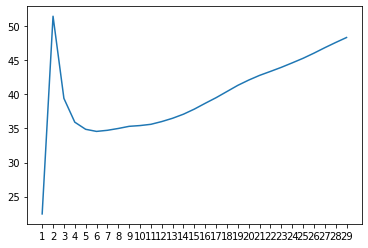

In [436]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {best_MAE}, with X={best_feat_vec_len_MAE + 1} (just copies high from prev day)")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with X={best_feat_vec_len_MAPE + 1} (just copies high from prev day)")

MAE_errors_copy = MAE_errors.copy()
MAPE_errors_copy = MAPE_errors.copy()

print("\n")

del MAE_errors_copy[best_feat_vec_len_MAE]
del MAPE_errors_copy[best_feat_vec_len_MAPE]

sec_feat_vec_len_MAE, sec_best_MAE = min(enumerate(MAE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAE is {sec_best_MAE}, with non-trivial X={sec_feat_vec_len_MAE + 1}")

sec_feat_vec_len_MAPE, sec_best_MAPE = min(enumerate(MAPE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAPE is {round(sec_best_MAPE, 3)}%, with non-trivial X={sec_feat_vec_len_MAPE + 1}")

Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [228]:
# prepare training data

def prep_data(feature_vec_len):
    features = []
    labels = []
    df_len = len(df_filtered_ext.values)


    for ind in range(df_len):
        feature_vec = []
        if ind < df_len - feature_vec_len:
            for ind2 in range(feature_vec_len):
                feature = df_filtered_ext.loc[ind + ind2]["High"]
                feature_vec.append(feature)

            label = df_filtered_ext.loc[ind + ind2 + 1]["High"]
            labels.append(label)
            features.append(feature_vec)

    features = np.array(features)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)

    # Shuffle only the training set
    shuffle_indices = np.arange(len(X_train))
    np.random.shuffle(shuffle_indices)

    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]


    feature_scaler = StandardScaler()
    label_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    y_train_scaled = label_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = label_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler


In [229]:
# init model

def create_model(feature_vec_len):
    model = Sequential()
    model.add(Dense(units=8, input_dim=feature_vec_len, activation='relu'))
    model.add(Dense(units=4, activation='relu'))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [235]:
# training

def train(model, X_train_scaled, y_train_scaled):
    history = model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=1, verbose=0)
    return history

In [231]:
# training loss plotting
def plot_training_loss(history):
    training_loss = history.history["loss"]
    plt.plot(training_loss)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.show()

In [232]:
# eval

def eval(model, label_scaler, X_test_scaled, y_test_scaled):
    y_pred_scaled = model.predict(X_test_scaled)

    y_pred = label_scaler.inverse_transform(y_pred_scaled)
    y_test = label_scaler.inverse_transform(y_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    return mse, y_test, y_pred

In [254]:
def hyperparam_search(m, model):
    errors = []
    for feat_vec_len in tqdm(range(1,m)):
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler = prep_data(feat_vec_len)
        model = create_model(feat_vec_len)
        history = train(model, X_train_scaled, y_train_scaled)
        mse, y_test, y_pred = eval(model, label_scaler, X_test_scaled, y_test_scaled)
        errors.append(mse)    
    return errors

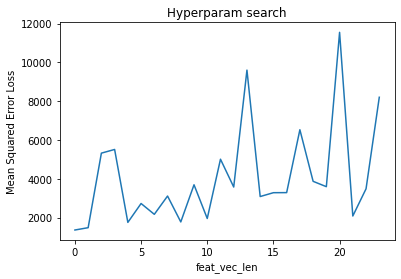

In [237]:
plt.plot(errors)
plt.title('Hyperparam search')
plt.xlabel('feat_vec_len')
plt.ylabel('Mean Squared Error Loss')
plt.show()    

In [239]:
sec_best_X, sec_best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with feature vec length={sec_best_X+1}")

Lowest MSE is 1367.4883922130014, with feature vec length=1


In [256]:
def aux1(errors):
    plt.plot(errors)
    plt.title('Hyperparam search')
    plt.xlabel('feat_vec_len')
    plt.ylabel('Mean Squared Error Loss')
    plt.show()    
    sec_best_X, sec_best_MSE = min(enumerate(errors), key=lambda x: x[1])
    print(f"Lowest MSE is {sec_best_MSE}, with feature vec length={sec_best_X+1}")

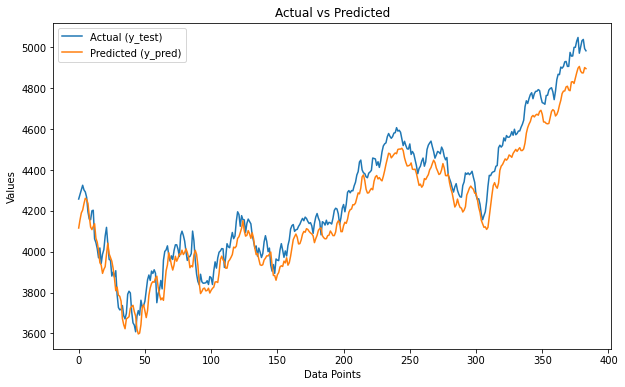

In [240]:
# Plot y_test and y_pred with a larger chart size
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(y_test, label='Actual (y_test)')
plt.plot(y_pred, label='Predicted (y_pred)')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.show()

### 3. RNN

In [241]:
from keras.layers import Dense, SimpleRNN

In [245]:
# prep data

feature_vec_len = 15

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler = prep_data(feat_vec_len)

In [260]:
# model

rnn = Sequential()
rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
rnn.add(Dense(units=1))
rnn.compile(optimizer='adam', loss=['mean_squared_error', 'mae'])

In [261]:
# train

rnn_history = rnn.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/50
24/24 [==============================] - 2s 21ms/step - loss: 0.0449 - val_loss: 0.0083
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 5/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 9/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/50
24/24

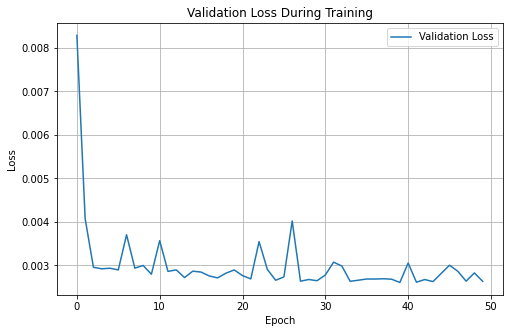

In [262]:
# plot val loss

val_loss = rnn_history.history['val_loss']

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

In [263]:
# eval
# def eval(model, label_scaler, X_test_scaled, y_test_scaled):

mse, y_test, y_pred = eval(rnn, label_scaler, X_test_scaled, y_test_scaled)

print(mse)

12/12 [==============================] - 0s 3ms/step
1501.2307696796718


In [255]:
# def hyperparam_search(m, feat_vec_len, model):

errors = hyperparam_search(25, rnn)

  0%|          | 0/24 [00:00<?, ?it/s]

13/13 [==============================] - 0s 2ms/step


  4%|▍         | 1/24 [00:27<10:32, 27.49s/it]

13/13 [==============================] - 0s 2ms/step


  8%|▊         | 2/24 [00:54<10:04, 27.47s/it]

13/13 [==============================] - 0s 2ms/step


 12%|█▎        | 3/24 [01:23<09:50, 28.11s/it]

13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 4/24 [01:53<09:36, 28.82s/it]

13/13 [==============================] - 0s 2ms/step


 21%|██        | 5/24 [02:25<09:25, 29.74s/it]

13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 6/24 [03:00<09:30, 31.71s/it]

13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 7/24 [03:39<09:40, 34.16s/it]

13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 8/24 [04:14<09:09, 34.35s/it]

13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 9/24 [04:49<08:36, 34.46s/it]

13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 10/24 [05:25<08:09, 34.95s/it]

13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 11/24 [05:59<07:30, 34.64s/it]

13/13 [==============================] - 0s 2ms/step


 50%|█████     | 12/24 [06:33<06:55, 34.65s/it]

13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 13/24 [07:11<06:30, 35.54s/it]

13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 14/24 [07:48<06:00, 36.04s/it]

13/13 [==============================] - 0s 2ms/step


 62%|██████▎   | 15/24 [08:26<05:28, 36.45s/it]

13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 16/24 [09:04<04:55, 36.93s/it]

13/13 [==============================] - 0s 2ms/step


 71%|███████   | 17/24 [09:43<04:23, 37.67s/it]

13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 18/24 [10:22<03:48, 38.15s/it]

13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 19/24 [11:02<03:13, 38.74s/it]

13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 20/24 [11:44<02:38, 39.62s/it]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 21/24 [12:27<02:01, 40.64s/it]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 22/24 [13:08<01:21, 40.81s/it]

13/13 [==============================] - 0s 1ms/step


 96%|█████████▌| 23/24 [13:51<00:41, 41.47s/it]

12/12 [==============================] - 0s 2ms/step


100%|██████████| 24/24 [14:34<00:00, 36.42s/it]


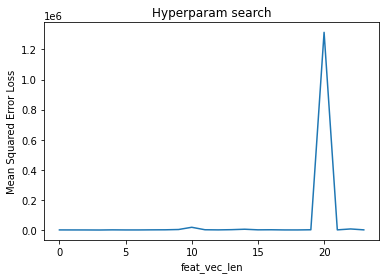

Lowest MSE is 1563.2681824462866, with feature vec length=4


In [257]:
aux1(errors)

In [259]:
rnn.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_170 (Dense)           (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4. Transformer

### 5. Reinforcement Learning


### 6. Brain